In [53]:
import cv2
import glob
import random
from math import *
import os
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

%matplotlib notebook

In [97]:
def read_fe_yaml(path):                                               
    fe_fs = cv2.FileStorage(path, cv2.FILE_STORAGE_READ)                    
    
    num_matches = int(fe_fs.getNode("number_of_matches").real())                 
    kps_node = fe_fs.getNode("keypoints")
    l_kp_mat = np.zeros((num_matches, 2))
    r_kp_mat = np.zeros((num_matches, 2))
    
    for i in range(num_matches):                                       
        kp_node = kps_node.getNode("kp_match_" + str(i))                    
        l_kp_mat[i, 0] = kp_node.getNode("l_x").real()
        l_kp_mat[i, 1] = kp_node.getNode("l_y").real()
        r_kp_mat[i, 0] = kp_node.getNode("r_x").real()
        r_kp_mat[i, 1] = kp_node.getNode("r_y").real()
                                                                            
    return [l_kp_mat, r_kp_mat]

def read_calib_yaml(path):                                               
    fs = cv2.FileStorage(path, cv2.FILE_STORAGE_READ)                                                                                 
    calib_node = fs.getNode("camera_calibrations")
    
    K_mat = []
    for i in range(2):               
        cam_node = calib_node.getNode("camera_" + str(i))
        K_mat.append(cam_node.getNode("K").mat())
    return K_mat

def random_color():                                                             
    r = random.randint(0, 255)
    b = random.randint(0, 255)
    g = random.randint(0, 255)                                                        
    return (r,b,g)

def draw_matches(image, kp_matches):                                               
    length_vec = []
    slope_vec = []
    for i in range(kp_matches[0].shape[0]):
        l_x = int(round(kp_matches[0][i, 0]))                                   
        l_y = int(round(kp_matches[0][i, 1]))                                   
        r_x = int(round(kp_matches[1][i, 0]))                                   
        r_y = int(round(kp_matches[1][i, 1]))
        x_diff = l_x - r_x
        y_diff = l_y - r_y
        length_vec.append(sqrt(x_diff**2 + y_diff**2))
        if x_diff == 0 or y_diff == 0:
            slope_vec.append(0)        
        else:
            slope_vec.append(y_diff/x_diff)
    
    length_vec = np.array(length_vec)
    slope_vec = np.array(slope_vec)

    length_mean = np.mean(length_vec)
    length_std = np.std(length_vec)
    
    slope_mean = np.mean(slope_vec)
    slope_std = np.std(slope_vec)
    print("slope mean", slope_mean)
    print("slope std", slope_std)
    print("length mean", length_mean)
    print("length std", length_std)
    for i in range(kp_matches[0].shape[0]):
        l_x = int(round(kp_matches[0][i, 0]))                                   
        l_y = int(round(kp_matches[0][i, 1]))                                   
        r_x = int(round(kp_matches[1][i, 0]))                                   
        r_y = int(round(kp_matches[1][i, 1]))                                   
        slope = slope_vec[i]
        length = length_vec[i]
        line_color = (255,0,0)
        if abs(slope-slope_mean) < slope_std:
            line_color = (0,255,0)
        if abs(length-length_mean) < length_std:
            line_color = (0,0,255)

        color = random_color()                                          
        cv2.circle(image, (l_x, l_y), 3, color, -1)
        cv2.line(image, (l_x, l_y), (r_x, r_y), line_color, 1)
    
    return image, length_vec, slope_vec

def load_image(path):                                               
    return cv2.imread(path, 0)

def universal_reader(path, height=480, width=640, dtype="float32"):
    extension = path.split(".")[-1]
    if(extension =="exr"):
        pt = Imath.PixelType(Imath.PixelType.FLOAT)
        golden = OpenEXR.InputFile(path)
        dw = golden.header()['dataWindow']
        size = (dw.max.x - dw.min.x + 1, dw.max.y - dw.min.y + 1)
        redstr = golden.channel('R', pt)
        img_data = np.fromstring(redstr, dtype = np.float32)
        img_data.shape = (size[1], size[0]) # Numpy arrays are (row, col)

    if(extension=="raw"):
        img_data = np.fromfile(path, dtype=dtype)
        img_data = np.reshape(img_data, (height, width))
    if(extension=="pfm"):
        img_data = open(path, "rb")  # reopen the file
        
        pos = img_data.tell()  # Save the current position
        img_data.seek(0, 2)  # Seek to the end of the file
        length = img_data.tell()  # The current position is the length
        img_data.seek(pos)  # Return to the saved position
        
        img_data.seek(length-(height*width*4), os.SEEK_SET)  # seek
        
        img_data = np.fromfile(img_data, dtype=dtype)
        img_data = np.reshape(img_data, (height, width))
        img_data = np.flip(img_data, 0)

        #img_data[img_data>96.0] = 0.0
        #img_data[img_data<0.0] = 0.0
    if(extension=="png" or extension=="jpg"):
        img_data = cv2.imread(path,0)

    return img_data

def depth_from_disparity( l_kp, disparity, camera_mat, baseline):
    depth = (camera_mat[0,0]*baseline) / disparity
    homg_pt = [[l_kp[0]], [l_kp[1]], [1.0]]
    norm_pt = np.dot(np.linalg.inv(k_mats[0]), homg_pt)
    norm_pt_depth = sqrt(norm_pt[0]**2 + norm_pt[1]**2 + norm_pt[2]**2)
    
    scale = depth / norm_pt_depth
    
    return norm_pt*scale

def reconstruct_matches_disp(keypoint_matches, camera_mats):
    recon_pts = np.zeros((keypoint_matches[0].shape[0], 3))
    
    for i in range(keypoint_matches[0].shape[0]):
        disparity = keypoint_matches[0][i,0] - keypoint_matches[1][i,0]
        if not disparity:
            disparity = 0.01
        pt = depth_from_disparity( keypoint_matches[0][i,:], disparity, camera_mats[0], baseline)
        recon_pts[i, 0] = pt[0]
        recon_pts[i, 1] = pt[1]
        recon_pts[i, 2] = pt[2]
    
    return recon_pts

def reconstruct_matches_opencv(keypoint_matches, camera_mats, R, t):
    
    M_r = np.hstack((R, t))
    M_l = np.hstack((np.eye(3, 3), np.zeros((3, 1))))
    P_l = np.dot(camera_mats[0],  M_l)
    P_r = np.dot(camera_mats[1],  M_r)

    pt_4d_hom = cv2.triangulatePoints(P_l, P_r, keypoint_matches[0].T, keypoint_matches[1].T)
    pt_4d_hom /= pt_4d_hom[3]
    pt_3d = pt_4d_hom[:3, :].T * -1.0
    
    return pt_3d

def load_3d_GT_data(gt_disp_im, camera_mats, baseline):

    x = np.zeros((gt_disp_im.shape[0], gt_disp_im.shape[1]))
    y = np.zeros((gt_disp_im.shape[0], gt_disp_im.shape[1]))
    z = np.zeros((gt_disp_im.shape[0], gt_disp_im.shape[1]))

    for row_i in range(gt_disp_im.shape[0]):
        for col_i in range(gt_disp_im.shape[1]):
            disparity = gt_disp_im[row_i, col_i]
            pt = []
            if disparity < 0.00002:
                pt = [0.0, 0.0, 0.0]
            else:
                pt = depth_from_disparity( np.array([col_i, row_i]), disparity, camera_mats[0], baseline)

            x[row_i, col_i] = pt[0]
            y[row_i, col_i] = pt[1]
            z[row_i, col_i] = pt[2]
    return x, y, z

In [105]:
ds_name = "Synthetic/LivingRoomLinearCy_Axis"
log_dir = "/home/prowsome/Dyncal_Datasets/logs/FIRF"
ds_dir = "/home/prowsome/Dyncal_Datasets/datasets"
calib_fp = os.path.join(ds_dir, ds_name, "640x480/FactoryCameraCalibration.yml")
gt_disp_raw_fp = os.path.join(ds_dir, ds_name, "640x480/gt/0.raw")
image_fp = os.path.join(ds_dir, ds_name, "640x480/8bit/left/im0.png")
fe_fp = os.path.join(log_dir, ds_name, "640x480/8bit/0_FE_log.yaml")

# load data
k_mats = read_calib_yaml(calib_fp)
kp_match = read_fe_yaml(fe_fp)
gt_disp_im = universal_reader(gt_disp_raw_fp)

In [106]:
# Find Essential Matrix
E, mask = cv2.findEssentialMat(kp_match[0], kp_match[1], k_mats[0], method=cv2.RANSAC, threshold=1.0)
_, R, t, mask = cv2.recoverPose(E, kp_match[0], kp_match[1], k_mats[0])
baseline = 0.035

In [107]:
# Triangulate Points using OpenCV
t = np.array([[baseline], [0.0], [0.0]])
pt_3d = reconstruct_matches_opencv(kp_match, k_mats, R, t)

In [108]:
# compute depth from disparity
pt_3d_disp = reconstruct_matches_disp(kp_match, k_mats)

In [109]:
# plot GT depth and reconstructed points from both sources
x, y, z = load_3d_GT_data(gt_disp_im, k_mats, baseline)

<IPython.core.display.Javascript object>


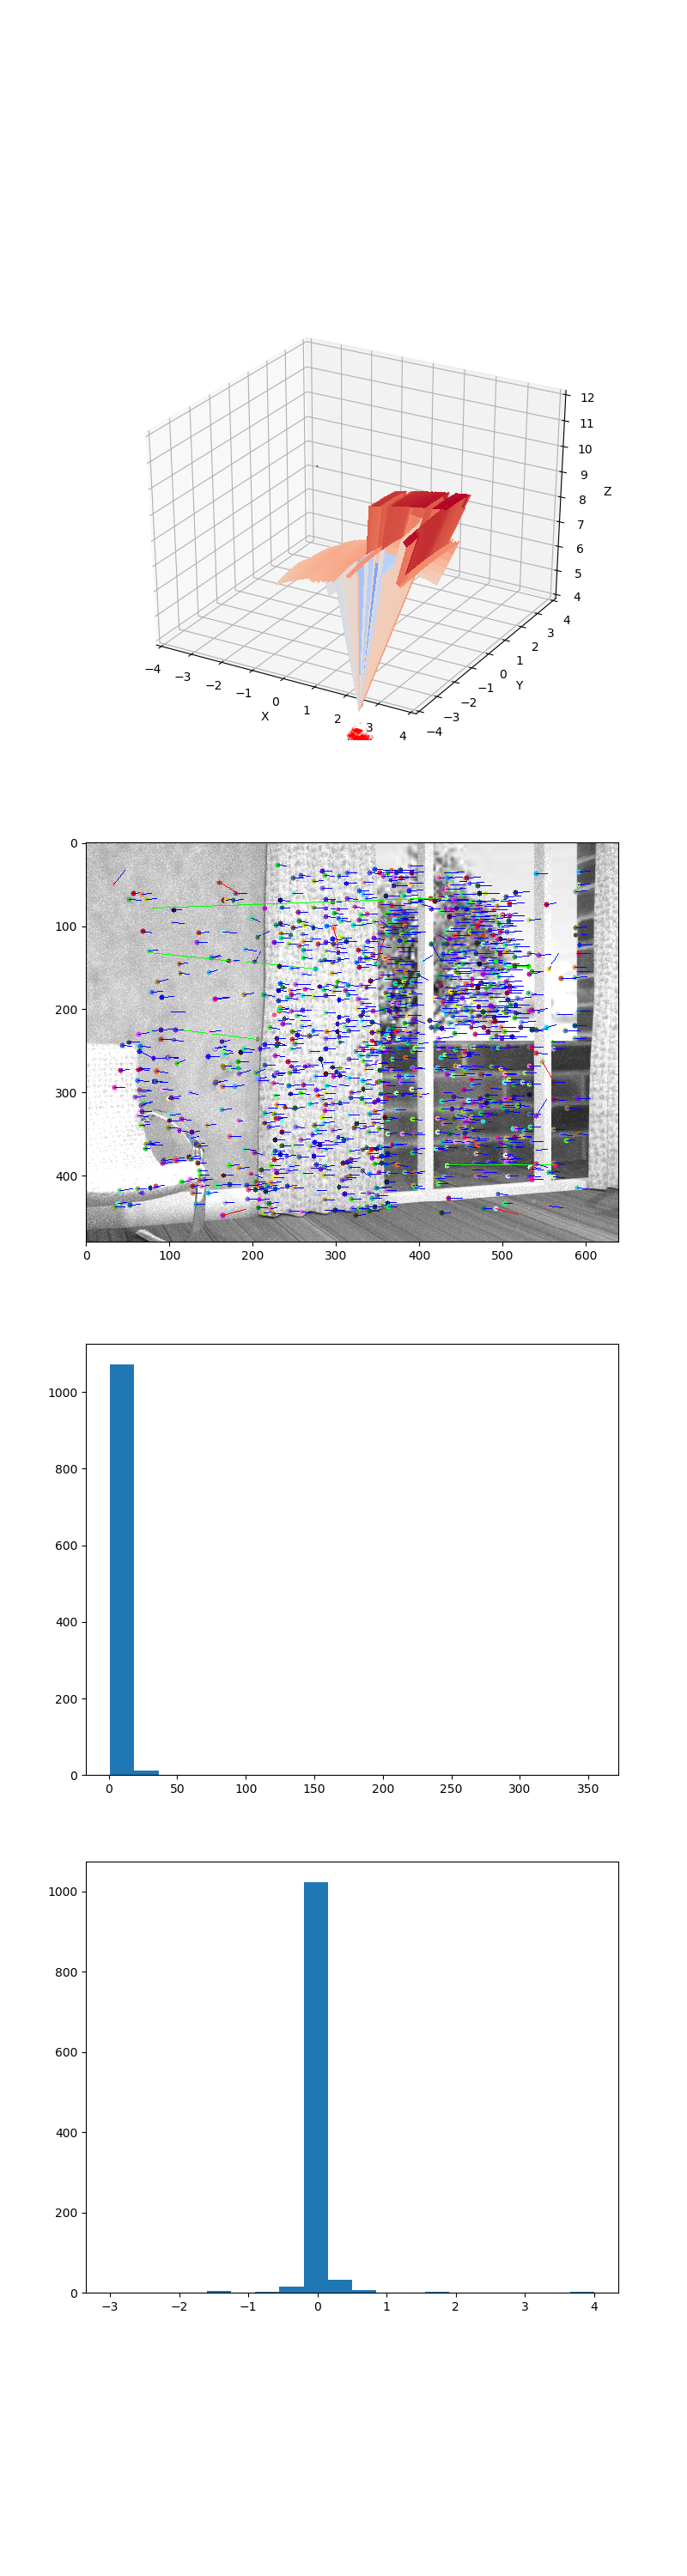

slope mean -0.0008270416602135026
slope std 0.24114188029580924
length mean 14.037108018811924
length std 12.954926548776104


In [110]:
fig = plt.figure(figsize=(8, 30))
ax = fig.add_subplot(411, projection='3d')
ax.set_xlabel("X")
ax.set_xlim((-4, 4))
ax.set_ylabel("Y")
ax.set_ylim((-4, 4))
ax.set_zlabel("Z")
ax.set_zlim((4, 12))
ax.plot_surface(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.scatter(pt_3d_disp[:,0], pt_3d_disp[:,1], pt_3d_disp[:,2], s=0.1, c='b', marker='^')
ax.scatter(pt_3d[:,0], pt_3d[:,1], pt_3d[:,2], s=0.1, c='r', marker='o')

ax = fig.add_subplot(412)
image_data = load_image(image_fp)
image_data = cv2.cvtColor(image_data, cv2.COLOR_GRAY2RGB)
image_data, length_vec, slope_vec = draw_matches(image_data, kp_match)
ax.imshow(image_data, cmap='gray')

ax = fig.add_subplot(413)
ax.hist(length_vec, 20)

ax = fig.add_subplot(414)
ax.hist(slope_vec, 20)

plt.show()

In [ ]:
# collect gt landmarks to comute errors
pt_3d_gt = np.zeros((pt_3d.shape[0], pt_3d.shape[1]))
for i in range(kp_match[0].shape[0]):
    l_kp_x = int(kp_match[0][i,0])
    l_kp_y = int(kp_match[1][i,1])
    
    pt_3d_gt[i, 0] = x[l_kp_y, l_kp_x]
    pt_3d_gt[i, 1] = y[l_kp_y, l_kp_x]
    pt_3d_gt[i, 2] = z[l_kp_y, l_kp_x]

# red dashes, blue squares and green triangles
oc_data = [pt_3d_gt[:,0]-pt_3d[:,0],
           pt_3d_gt[:,1]-pt_3d[:,1],
           pt_3d_gt[:,2]-pt_3d[:,2]]

dd_data = [pt_3d_gt[:,0]-pt_3d_disp[:,0],
           pt_3d_gt[:,1]-pt_3d_disp[:,1],
           pt_3d_gt[:,2]-pt_3d_disp[:,2]]

fig1, ax1 = plt.subplots()
ax1.set_title('OpenCV Errors')
ax1.boxplot(oc_data)
ax1.set_xticklabels(["X", "Y", "Z"])

fig2, ax2 = plt.subplots()
ax2.set_title('Depth from Disparity Errors')
ax2.boxplot(dd_data)
ax2.set_xticklabels(["X", "Y", "Z"])

plt.show()


In [ ]:
# Discover Outliers
z_errors = dd_data[2]

for i, error in enumerate(z_errors):
    if abs(error) > 5:
        l_kp = kp_match[0][i,:]
        r_kp = kp_match[1][i,:]
        print(l_kp, " -> ", r_kp, " error: ", error)

In [ ]:
def rotate_feature(x, y, camera_mat, rotation_mat):
    homg_ft = np.array([[x], [y], [1.0]])
    norm_pt = np.dot(np.linalg.inv(camera_mat), homg_ft)
    rot_pt = np.dot(norm_pt.T, rotation_mat)
    rot_ft = np.dot(camera_mat, rot_pt.T)
    rot_ft /= rot_ft[2]
    return rot_ft

angle = 1
tx = radians(angle)
ty = radians(angle)
tz = radians(angle)
Rx = np.array([[1,0,0], [0, cos(tx), -sin(tx)], [0, sin(tx), cos(tx)]]) 
Ry = np.array([[cos(ty), 0, -sin(ty)], [0, 1, 0], [sin(ty), 0, cos(ty)]]) 
Rz = np.array([[cos(tz), -sin(tz), 0], [sin(tz), cos(tz), 0], [0,0,1]]) 

x_rot_x_error_im = np.zeros((480, 640))
x_rot_y_error_im = np.zeros((480, 640))
y_rot_x_error_im = np.zeros((480, 640))
y_rot_y_error_im = np.zeros((480, 640))
z_rot_x_error_im = np.zeros((480, 640))
z_rot_y_error_im = np.zeros((480, 640))

for row_i in range(x_rot_x_error_im.shape[0]):
    for col_i in range(x_rot_x_error_im.shape[1]):
        
        x_rot_ft = rotate_feature(col_i, row_i, k_mats[0], Rx)
        y_rot_ft = rotate_feature(col_i, row_i, k_mats[0], Ry)
        z_rot_ft = rotate_feature(col_i, row_i, k_mats[0], Rz)

        x_rot_x_error_im[row_i, col_i] = x_rot_ft[0] - col_i
        x_rot_y_error_im[row_i, col_i] = x_rot_ft[1] - row_i
        y_rot_x_error_im[row_i, col_i] = y_rot_ft[0] - col_i
        y_rot_y_error_im[row_i, col_i] = y_rot_ft[1] - row_i
        z_rot_x_error_im[row_i, col_i] = z_rot_ft[0] - col_i
        z_rot_y_error_im[row_i, col_i] = z_rot_ft[1] - row_i

fig = plt.figure(figsize=(8, 15))
ax1 = fig.add_subplot(321)
ax1.imshow(x_rot_x_error_im, cmap='gray')
ax2 = fig.add_subplot(322)
ax2.imshow(x_rot_y_error_im, cmap='gray')
ax3 = fig.add_subplot(323)
ax3.imshow(y_rot_x_error_im, cmap='gray')
ax4 = fig.add_subplot(324)
ax4.imshow(y_rot_y_error_im, cmap='gray')
ax5 = fig.add_subplot(325)
ax5.imshow(z_rot_x_error_im, cmap='gray')
ax6 = fig.add_subplot(326)
ax6.imshow(z_rot_y_error_im, cmap='gray')
plt.show()
        

In [ ]:
print(np.amax(x_rot_x_error_im) )
print(np.amax(x_rot_y_error_im) )
print(np.amax(y_rot_x_error_im) )
print(np.amax(y_rot_y_error_im) )
print(np.amax(z_rot_x_error_im) )
print(np.amax(z_rot_y_error_im) )